
### Forecasting Brent Oil Price


In [172]:
import numpy as np #num ops
import matplotlib.pyplot as plt #plotting 
import pandas as pd #data structure
import math
from keras.models import Sequential #allow to create model lay by layes 
from keras.layers import Dense #reps fully connected layer 
from keras.layers import Activation #activation func , sigmoid, tanh
from keras.layers import Dropout #regularozation technique
from keras.layers import LSTM #part of RNN layer
from sklearn.preprocessing import MinMaxScaler #scale data from 0 to 1 
from sklearn.metrics import mean_squared_error #scikit, evaluate perf regr model

%matplotlib inline

It is recommended to fix the random number seed to ensure our results are reproducible.

In [173]:
# fix random seed for reproducibility
np.random.seed(0)

In [176]:
import pandas as pd

# Read Excel file into a Pandas DataFrame
excel_file = pd.read_excel('input/BOP.xls')

# Convert DataFrame to CSV format
excel_file.to_csv('input/BOP_formatted.csv', index=False)


In [177]:
# load the dataset
df = pd.read_csv('input/BOP_formatted.csv', usecols=[1], engine='python')
data = df.values
data = data.astype('float32')
print('Number of datapoints:',len(data))

Number of datapoints: 9285


In [178]:
#!pip install happybase


In [179]:
import pandas as pd

# Read data from the CSV file into a DataFrame
#file_path =  # Replace with your file path
df = pd.read_csv('input/BOP_formatted.csv')

# Convert the 'dates' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by the 'dates' column
df = df.sort_values('Date')

# Check if dates are consecutive
consecutive = all(df['Date'].iloc[i + 1] - df['Date'].iloc[i] == pd.Timedelta(days=1)
                  for i in range(len(df['Date']) - 1))

if consecutive:
    print("Dates in the column are consecutive.")
else:
    print("Dates in the column are not consecutive.")

Dates in the column are not consecutive.


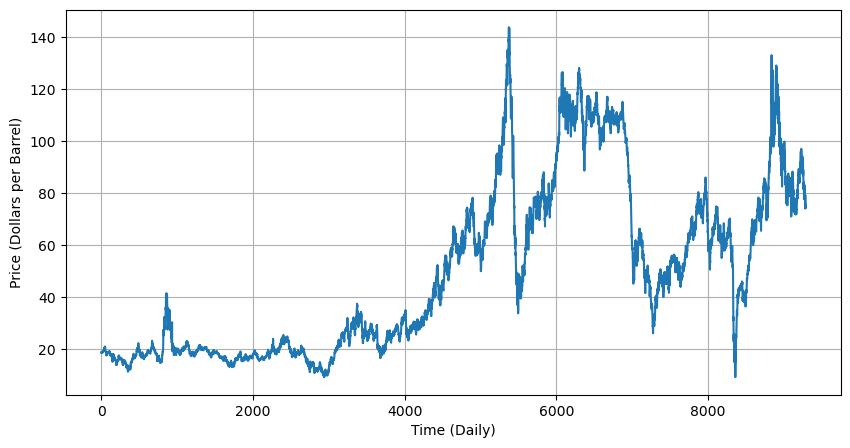

In [180]:
plt.figure(figsize=[10,5])
plt.xlabel('Time (Daily)')
plt.ylabel('Price (Dollars per Barrel)')
plt.grid()
plt.plot(data);

In [181]:
# split into train and test sets
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size

#data[0:6700], if data is 10k
train, test = data[0:train_size,:], data[train_size:len(data),:]
print('Train Set contains:', len(train),'datapoints')
print('Test Set contains:', len(test),'datapoints')

Train Set contains: 6220 datapoints
Test Set contains: 3065 datapoints


LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It is recommended to rescale (normalize) the data to the range of [0, 1]. This can be achieved using the MinMaxScaler preprocessing class from the scikit-learn library.

### Scale down train and test data
Use the MinMaxScaler to normalize the training and testing set betwee 0 and 1.  Name the normalized outputs norm_train and norm_test.

In [182]:
# add code here
from sklearn.preprocessing import MinMaxScaler

# Assuming you have your training and testing sets: train_set and test_set

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the scaler on the training set
norm_train = scaler.fit_transform(train)

# Transform the testing set using the same scaler
norm_test = scaler.transform(test)




### First Time Training

We can write a function that separates the data into an input array (X) which has all the datapoint at times t-i's, and an output array which contains the data at timepoint t.

The function takes two arguments: the data, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — the default is 1.

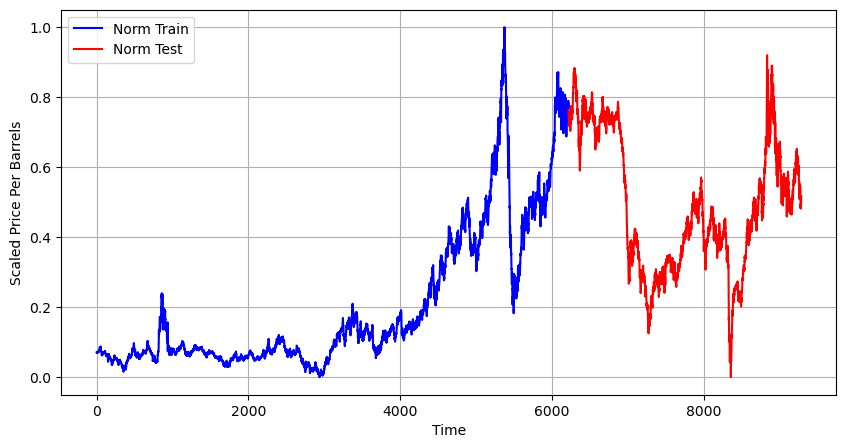

In [183]:
plt.figure(figsize=[10,5])
plt.xlabel('Time')
plt.ylabel('Scaled Price Per Barrels')
plt.grid()
plt.plot(range(len(train)),norm_train,'b')
plt.plot(range(len(train),len(train)+len(test)),norm_test,'r')
#plt.plot(range(len(train),len(test)),norm_test,'r')
plt.legend(['Norm Train','Norm Test']);



In [184]:
def split_X_y(data, look_back = 1):
  # add code here
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)



In [185]:
# reshape into X contains the data for times t-i ... t-2 t-1 and Y contains the data for times t
look_back = 1 # here we will only look at the previous datapoint to predict the next one
trainX, trainY = split_X_y(norm_train, look_back)
testX, testY = split_X_y(norm_test, look_back)

In [186]:
#print the shapes of the input features, which typically represent the input sequence
#, the shape will be (num_samples, time_steps, num_features)
print(trainX.shape)
print(testX.shape)

#print the shapes of the corresponding target or output values , which are usually the values to be predicted based on the input sequences
#shape will typically be (num_samples, num_output_features)
print(trainY.shape)
print(testY.shape)

(6219, 1, 1)
(3064, 1, 1)
(6219, 1)
(3064, 1)


The LSTM network expects the input data (X) to be provided in the form of: [sample, time steps, features].

Currently, the data is in the form: [samples, features], and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [187]:
# # reshape input to be [samples, time steps, features]
#samples refers to the number of data points or sequences. row
#time steps represents the sequence length or the number of time steps in each sequence.
#features indicates the number of features or variables in each time step of the sequence. column

#trainX.shape[0] corresponds to the number of samples or rows in the original trainX.
#1 represents the number of time steps in the reshaped array.
#trainX.shape[1] indicates the number of features or columns in each time step of the original trainX.
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1])) 

testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1])) 

In [188]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(6219, 1, 1)
(3064, 1, 1)
(6219, 1)
(3064, 1)


We will now design and fit our LSTM network.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 20 epochs and a batch size of 1 is used.

## Fit data in LSTM Model

In [189]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) #.add(no of mem unit, input_shape) 
model.add(Dense(1))#(neuron no )
model.compile(loss='mean_squared_error', optimizer='adam') #(loss function, optimizer algorithm)

# Fit the model on training data
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2) #(input x,input y, no of epocs, no sample, verbose)

Epoch 1/20
6219/6219 - 13s - loss: 0.0083 - 13s/epoch - 2ms/step
Epoch 2/20
6219/6219 - 11s - loss: 1.0707e-04 - 11s/epoch - 2ms/step
Epoch 3/20
6219/6219 - 12s - loss: 1.0118e-04 - 12s/epoch - 2ms/step
Epoch 4/20
6219/6219 - 12s - loss: 9.5386e-05 - 12s/epoch - 2ms/step
Epoch 5/20
6219/6219 - 12s - loss: 9.2050e-05 - 12s/epoch - 2ms/step
Epoch 6/20
6219/6219 - 11s - loss: 8.8614e-05 - 11s/epoch - 2ms/step
Epoch 7/20
6219/6219 - 11s - loss: 8.6646e-05 - 11s/epoch - 2ms/step
Epoch 8/20
6219/6219 - 11s - loss: 8.4928e-05 - 11s/epoch - 2ms/step
Epoch 9/20
6219/6219 - 11s - loss: 8.5623e-05 - 11s/epoch - 2ms/step
Epoch 10/20
6219/6219 - 11s - loss: 8.2588e-05 - 11s/epoch - 2ms/step
Epoch 11/20
6219/6219 - 11s - loss: 8.3134e-05 - 11s/epoch - 2ms/step
Epoch 12/20
6219/6219 - 11s - loss: 7.9853e-05 - 11s/epoch - 2ms/step
Epoch 13/20
6219/6219 - 11s - loss: 7.9688e-05 - 11s/epoch - 2ms/step
Epoch 14/20
6219/6219 - 11s - loss: 8.0027e-05 - 11s/epoch - 2ms/step
Epoch 15/20
6219/6219 - 11s - los

Once the model is fit, we can estimate the performance of the model on both the training and testing datasets. 

Note that we must invert (un-normalize) the predictions before calculating error scores to ensure that performance is reported in the same units as the original data.

# Check regression performance

In [190]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
'''
#========================================================================

num_features = trainX.shape[2]
# Forecast into the future (example assuming predicting 10 steps ahead)
future_steps = 10
last_sequence = train[-look_back:]  # Last sequence from training data

forecasted_values = []  # To store forecasted values

for _ in range(future_steps):
    # Reshape last sequence to match model input shape
    last_sequence = last_sequence.reshape((1, look_back, num_features))
    

    # Predict next value
    next_prediction = model.predict(last_sequence)[0][0]

    # Append the prediction to forecasted values
    forecasted_values.append(next_prediction)

    # Update the last sequence by removing the first value and adding the prediction
    last_sequence = np.append(last_sequence[:, 1:, :], [[next_prediction]], axis=1)
    


# Print the forecasted values
print("Forecasted values:", forecasted_values)

#========================================================================
'''
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainYTrue = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testYTrue = scaler.inverse_transform(testY)


# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYTrue, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYTrue, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

96/96 [==============================] - 0s 1ms/step
Train Score: 1.07 RMSE
Test Score: 1.63 RMSE


Predictions have been generates using the model for both the train and test dataset. We can also visualize the results to have an indication for how the model works.

When plotting the data, we must shift the predictions by the look_back in time to align on the x-axis with the original dataset. The data is presented with the original dataset as black dots, the predictions for the training dataset in blue, and the predictions on the test dataset in red.

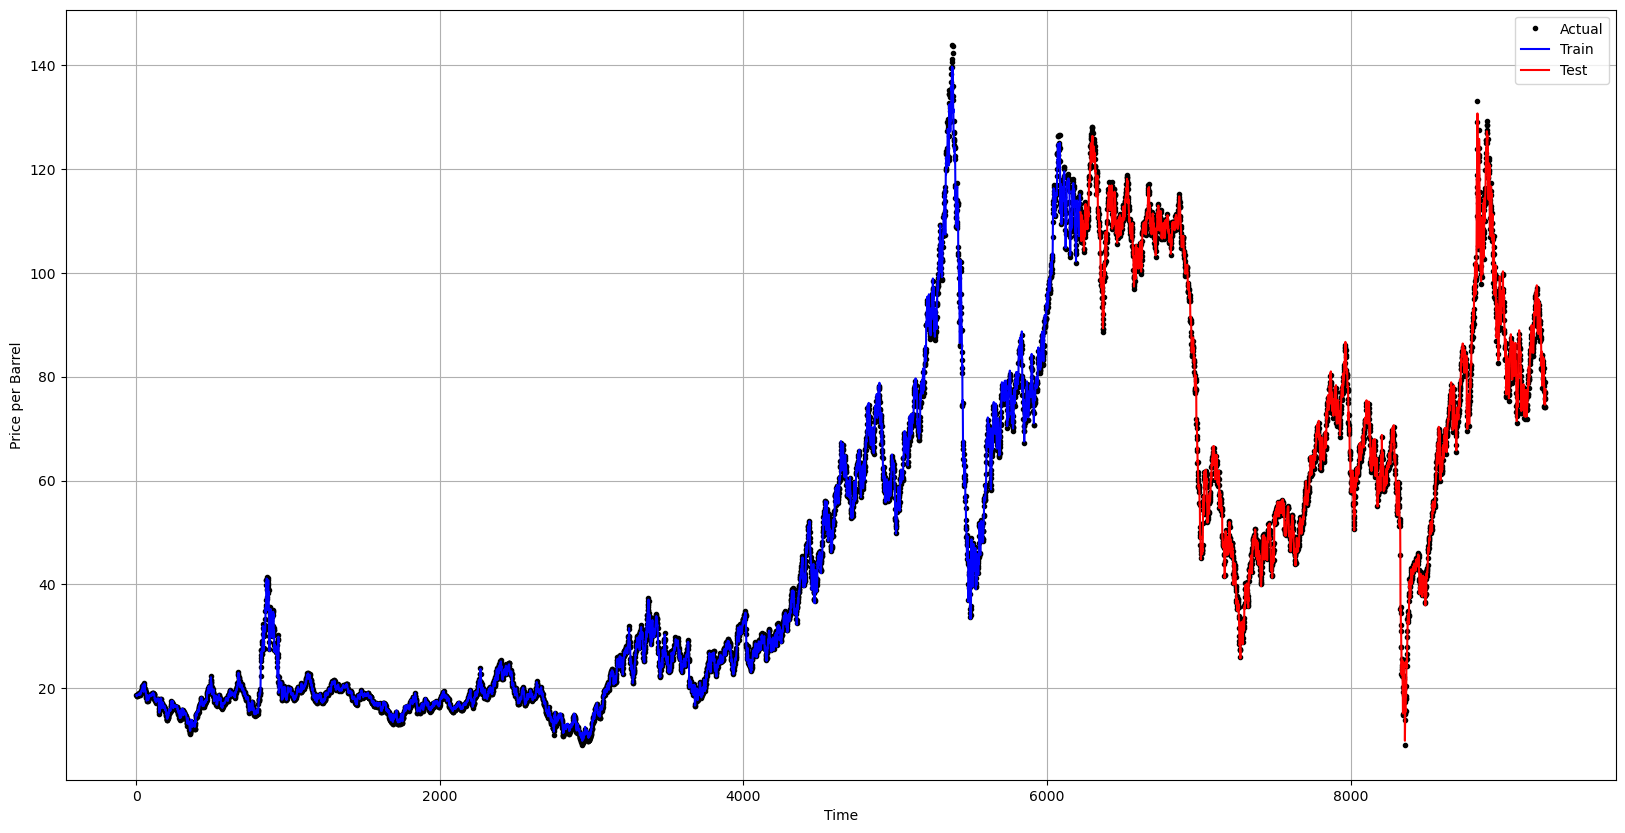

In [191]:
plt.figure(figsize=[20,10])
plt.xlabel('Time')
plt.ylabel('Price per Barrel')
plt.grid()
plt.plot(range(len(data)),data,'k.')
plt.plot(range(look_back,
               len(trainPredict)+
               look_back),trainPredict,'b')
plt.plot(range(len(trainPredict)+2*look_back,len(trainPredict)+len(testPredict)+2*look_back),testPredict,'r')
plt.legend(['Actual','Train','Test']);

### Hyperparameter Tuning

Improve the results above by trying the following:
- Increase the number of epochs
- Increase the look_back value
- Modify the Architecture
- Other

In [192]:
# reshape into X contains the data for times t-i ... t-2 t-1 and Y contains the data for times t
look_back = 2 # here we will only look at the previous datapoint to predict the next one
trainX, trainY = split_X_y(norm_train, look_back)
testX, testY = split_X_y(norm_test, look_back)

In [193]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(6218, 2, 1)
(6218, 1)
(3063, 2, 1)
(3063, 1)


In [194]:
# # reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [195]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(6218, 1, 2)
(6218, 1)
(3063, 1, 2)
(3063, 1)


In [196]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=40, batch_size=1, verbose=2)

Epoch 1/40
6218/6218 - 14s - loss: 0.0033 - 14s/epoch - 2ms/step
Epoch 2/40
6218/6218 - 12s - loss: 1.0168e-04 - 12s/epoch - 2ms/step
Epoch 3/40
6218/6218 - 12s - loss: 1.0107e-04 - 12s/epoch - 2ms/step
Epoch 4/40
6218/6218 - 11s - loss: 9.6546e-05 - 11s/epoch - 2ms/step
Epoch 5/40
6218/6218 - 11s - loss: 9.4812e-05 - 11s/epoch - 2ms/step
Epoch 6/40
6218/6218 - 12s - loss: 9.7212e-05 - 12s/epoch - 2ms/step
Epoch 7/40
6218/6218 - 12s - loss: 9.1563e-05 - 12s/epoch - 2ms/step
Epoch 8/40
6218/6218 - 12s - loss: 9.3339e-05 - 12s/epoch - 2ms/step
Epoch 9/40
6218/6218 - 12s - loss: 8.9855e-05 - 12s/epoch - 2ms/step
Epoch 10/40
6218/6218 - 12s - loss: 8.9878e-05 - 12s/epoch - 2ms/step
Epoch 11/40
6218/6218 - 12s - loss: 8.6063e-05 - 12s/epoch - 2ms/step
Epoch 12/40
6218/6218 - 12s - loss: 8.4619e-05 - 12s/epoch - 2ms/step
Epoch 13/40
6218/6218 - 12s - loss: 8.2136e-05 - 12s/epoch - 2ms/step
Epoch 14/40
6218/6218 - 12s - loss: 8.2935e-05 - 12s/epoch - 2ms/step
Epoch 15/40
6218/6218 - 12s - los

In [203]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainYTrue = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testYTrue = scaler.inverse_transform(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYTrue, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYTrue, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

96/96 [==============================] - 0s 2ms/step
Train Score: 1.67 RMSE
Test Score: 2.62 RMSE


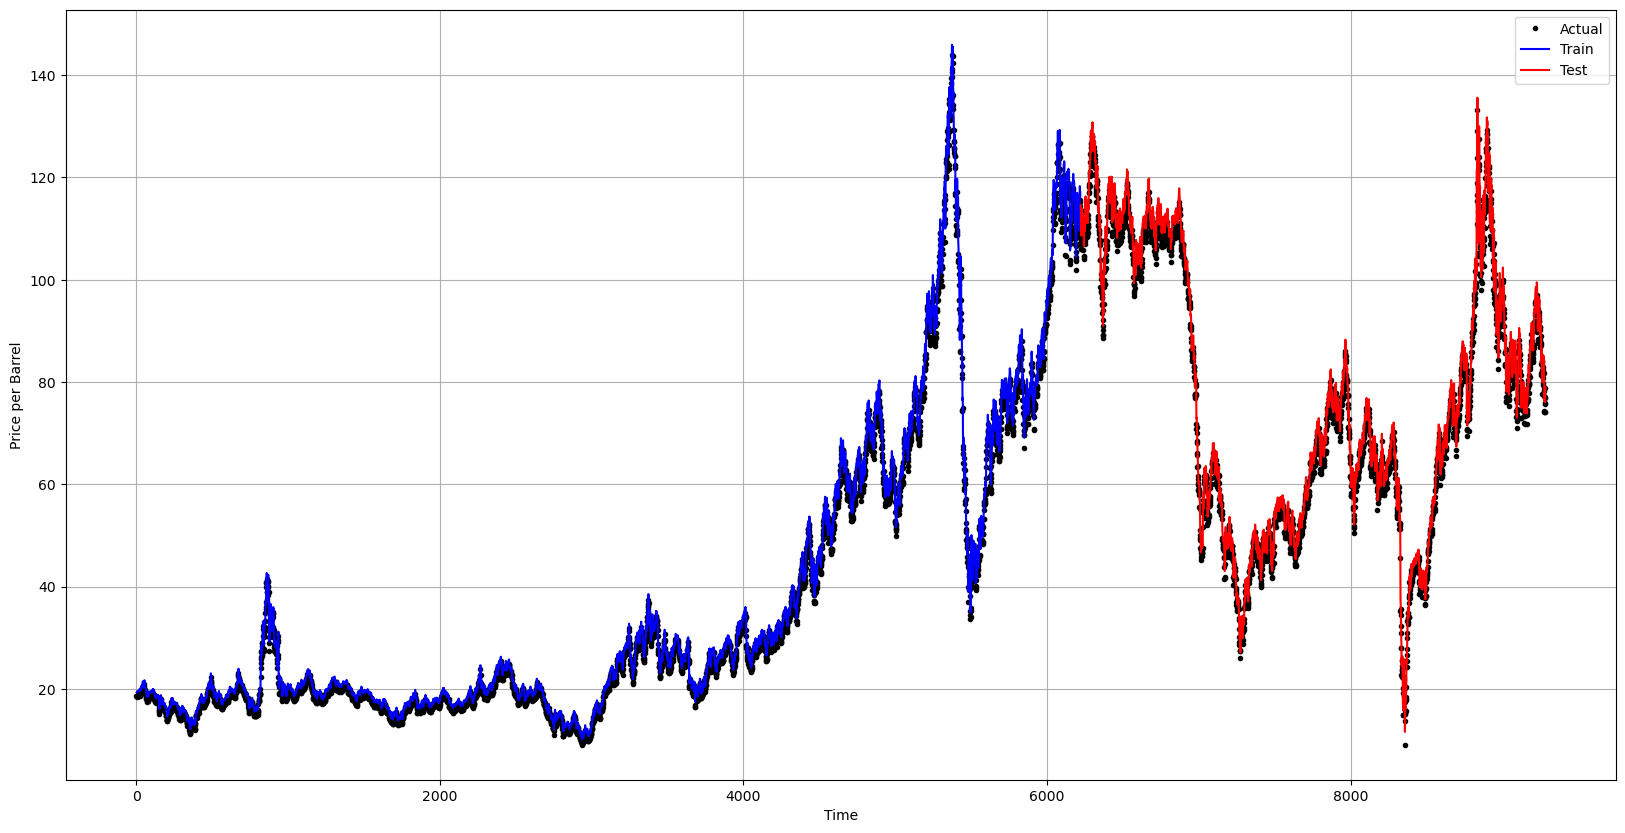

In [200]:
plt.figure(figsize=[20,10])
plt.xlabel('Time')
plt.ylabel('Price per Barrel')
plt.grid()

# Plotting the actual data
plt.plot(range(len(data)),data,'k.')

# Plotting the predictions on the training data
plt.plot(range(look_back,len(trainPredict)+look_back),trainPredict,'b')

# Plotting the predictions on the test data
plt.plot(range(len(trainPredict)+2*look_back,len(trainPredict)+len(testPredict)+2*look_back),testPredict,'r')

'''
# Extend the x-axis range for the forecast plot
forecast_range = range(len(trainPredict) + len(testPredict) + 2 * look_back, 
                       len(trainPredict) + len(testPredict) + len(forecasted_data) + 2 * look_back)
plt.plot(forecast_range, forecasted_data, 'g')  # Replace 'forecasted_data' with your forecasted values

# Adding legends for different plots
plt.legend(['Actual', 'Train', 'Test', 'Forecast'])
plt.show()
'''
plt.legend(['Actual','Train','Test']);

In [201]:
###What can be improved next?

#1. hidden layer
#2. activation function
#3. learning rate
#4. batch size

#extended forecast 